In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
tf.config.run_functions_eagerly(True)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #esta linea salva vidas
tf.config.experimental_run_functions_eagerly(False)

In [40]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Miguel/Desktop/Fotos para IA/Reptiles/Cocodrilo vs iguana',
    labels='inferred',
    label_mode="binary",#probar a poner binario 
    class_names=['Cocodrilo', 'Iguana'],
    color_mode='rgb',
    batch_size=None, #Se especificara mas adelante
    image_size=(224,224), #Redimension de imagenes
    shuffle=True,  #Baraja las imagenes
    seed=123,#Semilla estatica
    validation_split=0.15,
    subset="training",

)

Found 2120 files belonging to 2 classes.
Using 1802 files for training.


In [41]:
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Miguel/Desktop/Fotos para IA/Reptiles/Cocodrilo vs iguana',
    labels='inferred',
    label_mode="binary",
    class_names=['Cocodrilo', 'Iguana'],
    color_mode='rgb',
    batch_size=None, #Se especificara mas adelante
    image_size=(224,224), #Para redimensionar las imagenes
    shuffle=True,  #Baraja las imagenes
    seed=123,#Semilla estatica
    validation_split=0.15,
    subset="validation",


)

Found 2120 files belonging to 2 classes.
Using 318 files for validation.


In [42]:
#IMAGENES Y LABELS TRAIN
X=[]
Y=[]
for i,(img,label) in enumerate(ds_train):
  #img=cv2.resize(img.numpy(),(tamano_img, tamano_img)) ya hemmos redimensionado
  #img=img.reshape(tamano_img, tamano_img,3)
  X.append(img/255)#dividimos entre 255 para normalizar o se va todo a la mierda
  Y.append(label)

In [43]:
#IMAGENES Y LABELS TEST
Xtest=[]
Ytest=[]
for i,(img,label) in enumerate(ds_validation):
  #img=cv2.resize(img.numpy(),(tamano_img, tamano_img)) ya hemmos redimensionado
  #img=img.reshape(tamano_img, tamano_img,3)
  Xtest.append(img/255)#dividimos entre 255 para normalizar o se va todo a la mierda
  Ytest.append(label)

In [ ]:
#FUNCION PARA COMPROBAR SI LAS IMAGENES SON COMPATIBLES CON TENSORFLOW
from pathlib import Path
import imghdr
contador=0
data_dir = "C:/Users/Miguel/Desktop/Fotos para IA/Reptiles/Cocodrilo vs Aligator"
image_extensions = [".png", ".jpg",".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            contador+=1
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            contador+=1
            os.remove(filepath)
            
print(f"Numero de fotos eliminados: {contador}")

In [44]:
X=np.array(X)
Xtest=np.array(Xtest)
X[0]
Y=np.array(Y)
Ytest=np.array(Ytest)


In [45]:
#CREAMOS NUESTRO MODIFICADOR DE IMAGENES
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.01, #ojito con el shear range
    zoom_range=[0.6,1.2],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2]



)
data_gen_entrenamiento=datagen.flow(X,Y,batch_size=16)
data_gen_test=datagen.flow(Xtest,Ytest,batch_size=16)
#Le pasamos las imagenes y labels de entrenamiento
#Si algo falla aseurarse de tener las listas como np.array

In [ ]:
#FUNCION DE OPTIMIZACION DE EPOCAS (EN CONSTRUCCION)
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

# MODELO 1

In [49]:
def crear_modelo():
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3),padding='same'))
    model.add(tf.keras.layers.MaxPool2D(2,2))

    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(tf.keras.layers.MaxPool2D(2,2))

    #model.add(tf.keras.layers.Dropout(0.2))
    #model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
    #model.add(tf.keras.layers.MaxPool2D(2,2))

    #model.add(tf.keras.layers.Dropout(0.2))
    #model.add(tf.keras.layers.Conv2D(128*2,(3,3),activation='relu',padding='same'))
    #model.add(tf.keras.layers.MaxPool2D(2,2))
    
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100,activation='relu'))
    model.add(tf.keras.layers.Dense(2,activation='sigmoid'))
    return model

In [50]:
model= crear_modelo()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics="accuracy")

In [ ]:
history=model.fit(
    data_gen_entrenamiento,
    epochs=200,batch_size=16,
    validation_data=data_gen_test,
    steps_per_epoch=int(np.ceil(len(X)/float(16))),
    #steps_per_epoch = total_samples / batch_size
    validation_steps=int(np.ceil(len(Xtest)/float(16))),
    #validation_steps = np.ceil(numero_total_muestras_validacion / tamano_lote_validacion).astype(int)
)

Epoch 1/200
113/113 [==============================] - 26s 223ms/step - loss: 0.6877 - accuracy: 0.6065 - val_loss: 0.6792 - val_accuracy: 0.0377
Epoch 2/200
113/113 [==============================] - 26s 226ms/step - loss: 0.6823 - accuracy: 0.0716 - val_loss: 0.6765 - val_accuracy: 0.0597
Epoch 3/200
113/113 [==============================] - 25s 222ms/step - loss: 0.6812 - accuracy: 0.3524 - val_loss: 0.6884 - val_accuracy: 0.9874
Epoch 4/200
113/113 [==============================] - 25s 222ms/step - loss: 0.6820 - accuracy: 0.6315 - val_loss: 0.6752 - val_accuracy: 0.9497
Epoch 5/200
113/113 [==============================] - 25s 224ms/step - loss: 0.6794 - accuracy: 0.5566 - val_loss: 0.6781 - val_accuracy: 0.9591
Epoch 6/200
113/113 [==============================] - 25s 222ms/step - loss: 0.6826 - accuracy: 0.6265 - val_loss: 0.6939 - val_accuracy: 0.0094
Epoch 7/200
113/113 [==============================] - 25s 222ms/step - loss: 0.6807 - accuracy: 0.5233 - val_loss: 0.6831 -

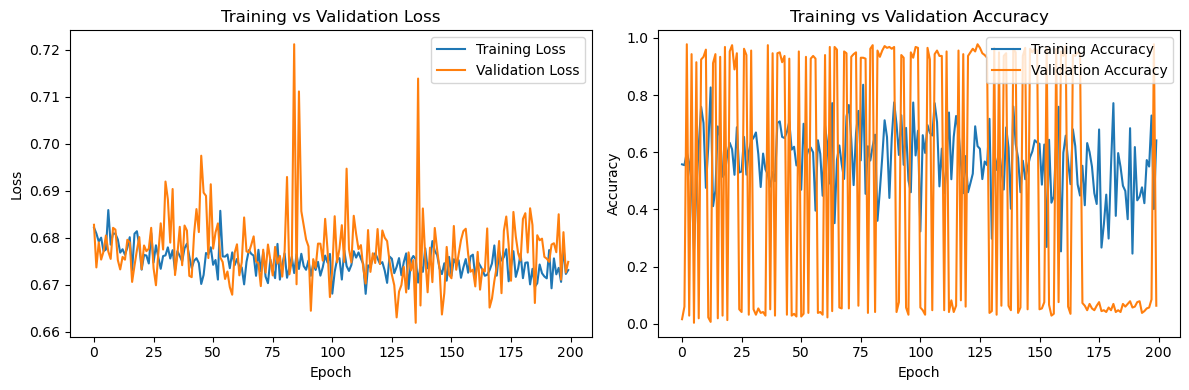

In [38]:
# Extraer la información de la pérdida y la precisión de los historiales
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Graficar la pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Graficar la precisión durante el entrenamiento y la validación
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Ajustar el diseño de los gráficos y mostrarlos
plt.tight_layout()
plt.show()

In [14]:
#HACEMOS UN TEST
test_loss = model.evaluate(Xtest, Ytest)
print(f"Test loss is: {test_loss}")

10/10 [==============================] - 0s 18ms/step - loss: 24268.8516 - accuracy: 0.4245
Test loss is: [24268.8515625, 0.4245283007621765]


In [ ]:
predicciones = model.predict(X)

# Imprimir las primeras 5 predicciones
print("Predicciones:")
print(predicciones[:5])